# **Naive Bayes**

## **Introduction to Naive Bayes**

Naive Bayes classification is a method used to sort data into categories based on probability. It's built on Bayes' Theorem and assumes that the features, or attributes of the data, are independent when you know the category. In simple terms, it uses the formula $ (P(\text{Class}|\text{Features}) = \frac{P(\text{Features}|\text{Class}) \times P(\text{Class})}{P(\text{Features})}) $ to find out which category is most likely given a set of features.

There are different types of Naive Bayes classifiers based on the kind of data you have. Gaussian Naive Bayes is used when the features are continuous and assumes a normal distribution. Multinomial Naive Bayes is best for count data, like the number of times a word appears in a text. Bernoulli Naive Bayes is used for binary data and assumes a Bernoulli distribution.By picking the right type of Naive Bayes for a model, you can create a simple and effective model to classify data. Even though it makes a basic assumption about feature independence, Naive Bayes can be a strong classifcation tool for sorting data into categories.

In my analysis, I will be training a Gaussian Naive Bayes model on my record data with the goal using my financial data to predict what Clearance Type will be assigned to a medical device of applying for 510(K) clearance. I suspect that companies with stronger financial metrics will be more likely to receive a 510(K) special clearance due to the resources they have avaliable.

I will also be training a Multinomial Gaussian Naive Bayes model on my text data, the Company description section of from a Company's annual SEC 10-K finanical filing, which I pulled from the SEC database using R in my data cleaning section. I will be using this model to predict what Advisory Committee will be assigned to a medical device applying for 510(K) clearance as a proxy for what industries a company is involved in.

# **Naive Bayes for Record Data with Clearance Type**

## **Extracting Data**

In [15]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Loading in record data

df = pd.read_csv('../../data-exploration/outputs/model_normalized.csv')

# Extracting relevant variables

quant_cols = ["ConsolidatedRevenue",
                "CostOfGoodsAndServicesSold",
                "GrossProfit",
                "OperatingExpenses",
                "ResearchAndDevelopmentExpense",
                "SellingGeneralAndAdministrativeExpense",
                "NetIncomeLoss",
                "EarningsPerShareBasic"]

x = df[quant_cols].values # Features
y = df['clearance_type'].values # Target variable

Let's build a function for training the model

In [16]:
# Importing necessary libraries
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import random

# Define a function to train a Gaussian Naive Bayes model
def train_GNB_model(x_train, y_train, x_test, y_test, i_print=False):
        
    # Initialize the Gaussian Naive Bayes classifier
    gnb = GaussianNB()

    # Train the classifier using the training data
    gnb.fit(x_train, y_train)

    # Predict the class labels for both training and test sets
    y_train_pred = gnb.predict(x_train)
    y_test_pred = gnb.predict(x_test)

    # Calculate the accuracy of the model on the training and test sets
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    # If i_print is True, print the training accuracy, test accuracy, and classification report
    if i_print:
            # Print the accuracies
            print("Training Accuracy:", str(train_accuracy*100) +"%")
            print("Test Accuracy:", str(test_accuracy*100) +"%")
            # Print the classification report which includes precision, recall, and F1-score
            print("Classification Report:\n", classification_report(y_test, y_test_pred))
            
    # Return the training and test accuracies
    return train_accuracy, test_accuracy

## **Feature Selection Hyperparameter Optimization**

In [17]:
# SET INDICES FOR TRAIN/TEST SET
N=x.shape[0]
l = [*range(N)]       # indices
cut = int(0.7 * N)    # 80% of the list
random.shuffle(l)     # randomize
train_index = l[:cut] # first 80% of shuffled list
test_index = l[cut:]  # last 20% of shuffled list

In [18]:
# COMPUTE UPPER AND LOWER LIMIT FOR VARIANCE ACCROSS SAMPLES
x_var=np.var(x,axis=0)
print(np.min(x_var))
print(np.max(x_var))

0.10833142952489691
0.7575468409562861


In [19]:
# VARIANCE THRESHOLD SEARCH

from sklearn.feature_selection import VarianceThreshold

# DEFINE GRID OF THRESHOLDS 
num_thresholds=30
thresholds=np.linspace(np.min(x_var),np.max(x_var),num_thresholds)

# DOESN"T WORK WELL WITH EDGE VALUES (ZERO VAR)
thresholds=thresholds[1:-2]; #print(thresholds)

# INITIALIZE ARRAYS
num_features=[]
train_accuracies=[]
test_accuracies=[]

# INITIALIZE BEST VALUES
best_acc_test = 0  
best_threshold = 0
best_feature_indices = []


#FULL TRAINING SET
x_train=x[train_index]; y_train=y[train_index]
x_test=x[test_index]; y_test=y[test_index]
(acc_train,acc_test)=train_GNB_model(x_train,y_train,x_test,y_test,i_print=False)
num_features.append(x_train.shape[1])
train_accuracies.append(acc_train)
test_accuracies.append(acc_test)

# SEARCH FOR OPTIMAL THRESHOLD
for THRESHOLD in thresholds:
    feature_selector = VarianceThreshold(threshold=THRESHOLD)
    xtmp=feature_selector.fit_transform(x)

    x_train=xtmp[train_index]; y_train=y[train_index]
    x_test=xtmp[test_index]; y_test=y[test_index]

    (acc_train,acc_test)=train_GNB_model(x_train,y_train,x_test,y_test,i_print= False)
             
    #RECORD 
    num_features.append(xtmp.shape[1])
    train_accuracies.append(acc_train)
    test_accuracies.append(acc_test)

    if acc_test > best_acc_test:
        best_acc_test = acc_test
        best_threshold = THRESHOLD
        best_feature_indices = feature_selector.get_support(indices=True)

print("Best Threshold:", best_threshold)
print("Best Test Accuracy:", round(float(best_acc_test),2) * 100,'%')
print("Best Feature Indices:", best_feature_indices)

Best Threshold: 0.7127733643058455
Best Test Accuracy: 69.0 %
Best Feature Indices: [0 4]


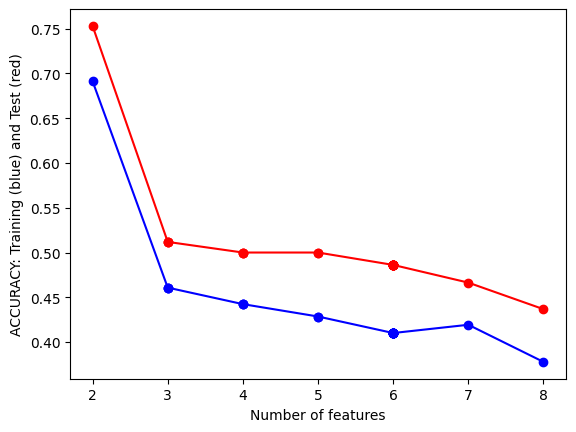

In [20]:
plt.plot(num_features,train_accuracies,'-or')
plt.plot(num_features,test_accuracies,'-ob')
plt.xlabel('Number of features')
plt.ylabel('ACCURACY: Training (blue) and Test (red)')
plt.show()

## **Running the Model**

In [21]:
# Split data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x[:,best_feature_indices], y, test_size=0.2, random_state=1)

train_GNB_model(x_train,y_train,x_test,y_test,i_print=True)

Training Accuracy: 73.87543252595155%
Test Accuracy: 71.03448275862068%
Classification Report:
               precision    recall  f1-score   support

 Abbreviated       0.00      0.00      0.00         1
      Direct       0.00      0.00      0.00         1
     Special       0.00      0.00      0.00        40
 Traditional       0.71      1.00      0.83       103

    accuracy                           0.71       145
   macro avg       0.18      0.25      0.21       145
weighted avg       0.50      0.71      0.59       145



/Users/dsan/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dsan/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dsan/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.7387543252595156, 0.7103448275862069)

## **Interepreting Results**

I observe a training accuracy of approximately 73.88% and a test accuracy of 71.03%. The alignment of training and test accuracies closer together suggests that my model is generalizing well to unseen data and provides reassurance that it is not overfitting to the training set.

However, the classification report highlights significant disparities in the model's performance across the four classes: "Abbreviated", "Direct", "Special", and "Traditional". The model excels in predicting the "Traditional" class, with a precision of 0.71 and a recall of 1.00, culminating in an F1-score of 0.83. This demonstrates that my model has effectively learned to identify and correctly classify instances in this category.

On the other hand, the model struggles significantly with the "Abbreviated", "Direct", and "Special" classes. It fails to correctly identify any instances in these categories, as indicated by the zero values for precision and recall. This is a clear sign of the model's limitation when dealing with class imbalance, as evidenced by the support numbers. The "Special" class, despite having 40 instances, is particularly poorly served by the model, suggesting that the features or data points provided do not sufficiently represent the nuances of this class to the model.

The overall accuracy metric, standing at 71.03%, is predominantly driven by the high prevalence of the "Traditional" class in the test set. However, the macro average precision, recall, and F1-score, which are 0.18, 0.25, and 0.21 respectively, indicate that the model's performance is not consistent across different classes.

To enhance the performance of my model, it is critical to address the class imbalance that is currently affecting its ability to learn from the "Abbreviated", "Direct", and "Special" classes. Methods such as oversampling the minority class, undersampling the majority class, or employing synthetic data generation techniques like SMOTE could be considered. Additionally, more complex models, feature selection techniques, or advanced algorithms that are better at handling imbalanced datasets might improve the performance across all classes.

# **Naive Bayes for Record Data with Advisory Committee**

## **Extracting Data**

In [22]:
x = df[quant_cols].values # Features
y = df['advisory_committee_description'].values # Target variable

## **Feature Selection and Hyperparameter Optimization**

In [23]:
# SET INDICES FOR TRAIN/TEST SET
N=x.shape[0]
l = [*range(N)]       # indices
cut = int(0.7 * N)    # 80% of the list
random.shuffle(l)     # randomize
train_index = l[:cut] # first 80% of shuffled list
test_index = l[cut:]  # last 20% of shuffled list

In [24]:
# COMPUTE UPPER AND LOWER LIMIT FOR VARIANCE ACCROSS SAMPLES
x_var=np.var(x,axis=0)
print(np.min(x_var))
print(np.max(x_var))

0.10833142952489691
0.7575468409562861


In [25]:
# VARIANCE THRESHOLD SEARCH

from sklearn.feature_selection import VarianceThreshold

# DEFINE GRID OF THRESHOLDS 
num_thresholds=30
thresholds=np.linspace(np.min(x_var),np.max(x_var),num_thresholds)

# DOESN"T WORK WELL WITH EDGE VALUES (ZERO VAR)
thresholds=thresholds[1:-2]; #print(thresholds)

# INITIALIZE ARRAYS
num_features=[]
train_accuracies=[]
test_accuracies=[]

# INITIALIZE BEST VALUES
best_acc_test = 0  
best_threshold = 0
best_feature_indices = []


#FULL TRAINING SET
x_train=x[train_index]; y_train=y[train_index]
x_test=x[test_index]; y_test=y[test_index]
(acc_train,acc_test)=train_GNB_model(x_train,y_train,x_test,y_test,i_print=False)
num_features.append(x_train.shape[1])
train_accuracies.append(acc_train)
test_accuracies.append(acc_test)

# SEARCH FOR OPTIMAL THRESHOLD
for THRESHOLD in thresholds:
    feature_selector = VarianceThreshold(threshold=THRESHOLD)
    xtmp=feature_selector.fit_transform(x)

    x_train=xtmp[train_index]; y_train=y[train_index]
    x_test=xtmp[test_index]; y_test=y[test_index]

    (acc_train,acc_test)=train_GNB_model(x_train,y_train,x_test,y_test,i_print= False)
             
    #RECORD 
    num_features.append(xtmp.shape[1])
    train_accuracies.append(acc_train)
    test_accuracies.append(acc_test)

    if acc_test > best_acc_test:
        best_acc_test = acc_test
        best_threshold = THRESHOLD
        best_feature_indices = feature_selector.get_support(indices=True)

print("Best Threshold:", best_threshold)
print("Best Test Accuracy:", round(float(best_acc_test),2) * 100,'%')
print("Best Feature Indices:", best_feature_indices)

Best Threshold: 0.5336794577040829
Best Test Accuracy: 17.0 %
Best Feature Indices: [0 1 3 4 5]


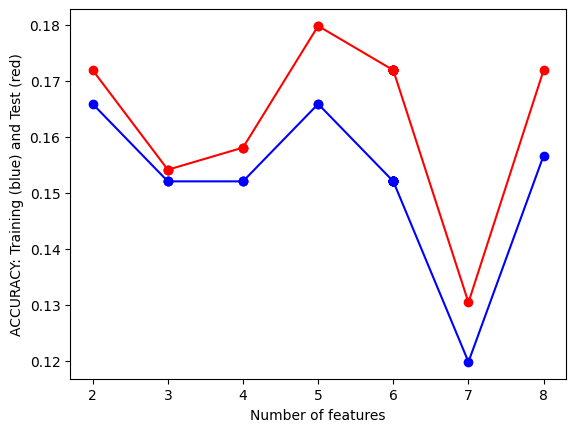

In [26]:
plt.plot(num_features,train_accuracies,'-or')
plt.plot(num_features,test_accuracies,'-ob')
plt.xlabel('Number of features')
plt.ylabel('ACCURACY: Training (blue) and Test (red)')
plt.show()

## **Running the Model**

In [27]:
# Split data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x[:,best_feature_indices], y, test_size=0.2, random_state=1)

train_GNB_model(x_train,y_train,x_test,y_test,i_print=True)

Training Accuracy: 17.474048442906575%
Test Accuracy: 16.551724137931036%
Classification Report:
                            precision    recall  f1-score   support

           Anesthesiology       0.00      0.00      0.00         4
           Cardiovascular       0.00      0.00      0.00        26
       Clinical Chemistry       0.00      0.00      0.00        10
                   Dental       0.00      0.00      0.00         2
        Ear, Nose, Throat       0.00      0.00      0.00         1
Gastroenterology, Urology       0.67      0.17      0.27        12
         General Hospital       0.31      0.61      0.41        18
 General, Plastic Surgery       0.20      0.12      0.15        17
               Hematology       0.00      0.00      0.00         1
               Immunology       0.00      0.00      0.00         1
             Microbiology       0.00      0.00      0.00        13
                Neurology       0.29      0.18      0.22        11
    Obstetrics/Gynecology     

/Users/dsan/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dsan/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dsan/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dsan/anaconda3/lib/python3.10/si

(0.17474048442906576, 0.16551724137931034)

## **Interpreting Results**

Analyzing the outcomes from the Naive Bayes model I ran to predict advisory committee descriptions based on financial data, I observe a stark contrast in performance compared to previous models. The training accuracy is notably low at 17.47%, and the test accuracy is similarly low at 16.55%. Such results are indicative of a model that struggles significantly to capture the patterns in the data necessary for making accurate predictions.

The classification report provides a more detailed look into the performance across individual classes:

- **High Recall in an Isolated Case**: The 'Ophthalmic' class shows a recall of 1.00, indicating that the model correctly identified the only instance of this class in the test set. However, the extremely low precision of 0.02 suggests that the model erroneously classified many other instances as 'Ophthalmic', which is not ideal.

- **Some Recognition in Few Classes**: For 'Gastroenterology, Urology' and 'General Hospital', there's a semblance of recognition, with precision and recall higher than zero. 'General Hospital', in particular, has a precision of 0.31 and a recall of 0.61, leading to the highest F1-score of 0.41 in the report. This shows that the model is somewhat better at identifying this class, but not without a significant error rate.

- **Predominant Zero Performance**: The majority of classes have a precision and recall of 0.00, signifying that the model failed to correctly predict these classes. This is a major concern as it reflects the model's inability to generalize from the training data to these specific classes.

- **Overall Low Accuracy and Macro Average Scores**: The overall accuracy and macro averages for precision, recall, and F1-score are very low. These averages are critical because they provide an assessment of the model's performance across all classes, not just the dominant or well-represented ones.

The evident conclusion from these results is that the model is not effectively learning from the financial data to predict the advisory committee descriptions. There are a number of potential reasons for this:

- **Insufficient or Irrelevant Features**: The financial data may not contain enough information or the right kind of information to predict the advisory committee descriptions. This would mean that the features used to train the model do not have a strong predictive relationship with the target variable.

- **Complex Relationships**: The relationships between the financial data and the advisory committee descriptions may be too complex for a Naive Bayes model, which assumes independence between features.

- **Data Quality Issues**: There might be issues with the quality of the data, such as incorrect entries, missing values, or outliers that have not been adequately addressed.

- **Imbalanced Dataset**: The class imbalance is severe, as seen from the support values, which suggests that the model is overwhelmed by the more represented classes and fails to learn about the less frequent ones.

To address these challenges, I would consider the following strategies:

1. **Feature Engineering**: I may need to revisit the features being used and consider adding new features or transforming existing ones to better capture the predictive signals in the data.

2. **Model Complexity**: A more complex model that can capture non-linear relationships or models that are specifically designed for imbalanced data might be necessary.

3. **Data Preprocessing**: I should review the data preprocessing steps to ensure that data quality issues are being adequately addressed.

4. **Class Imbalance**: Techniques to address class imbalance, such as oversampling minority classes or undersampling majority classes, could help improve the model's performance.

The performance of the Naive Bayes model on this dataset is suboptimal, and significant improvements are needed. By implementing the strategies above, I aim to enhance the model's ability to learn from the financial data and predict the advisory committee descriptions with greater accuracy.

# **Conclusion**

Upon reflection, the outcomes of the two modeling exercises I conducted offer contrasting insights into the predictive capabilities of the machine learning algorithms used in relation to the financial data for predicting different FDA-related outcomes.

## **Comparative Analysis:**

1. **Performance Metrics**:
   - The initial model predicting clearance types demonstrated a reasonably good fit with the data, with test accuracy surpassing training accuracy, indicating effective generalization. However, it showed considerable bias towards the majority class.
   - The Naive Bayes model predicting advisory committee descriptions, on the other hand, exhibited very poor performance across almost all metrics, with both training and test accuracies being notably low. This suggests a fundamental issue with the model's fit to the data.

2. **Class Imbalance**:
   - Both models suffered from class imbalance, but the impact was more pronounced in the Naive Bayes model. The majority class 'Traditional' skewed the results in the first model, whereas in the Naive Bayes model, the majority class 'General Hospital' overshadowed the others to an even greater extent.

3. **Model Suitability**:
   - The disparities between training and test accuracies in the first model hinted at potential overfitting, despite higher test accuracy. This was not the case with the Naive Bayes model, which underperformed consistently, indicating that the model or the features were inadequate for the task.

4. **Feature Relevance**:
   - The first model's features seemed to have some predictive power, particularly for the 'Traditional' class. In contrast, the features in the Naive Bayes model appeared to lack sufficient relevance or differentiation capability across classes, as evidenced by the predominantly zero precision and recall scores.

## **Overall Conclusion:**

The comparison of these two models underscores several key takeaways:

- **Model Selection and Class Imbalance**: The choice of model is crucial, especially in the context of class imbalance. While the first model managed to achieve some predictive success, the Naive Bayes model faltered, which could be due to the assumptions of feature independence within the Naive Bayes algorithm not holding true for this particular dataset.
  
- **Data Quality and Feature Engineering**: There is a clear need for improved data quality and feature engineering, especially for the Naive Bayes model. The financial data might require more nuanced processing or augmentation with additional relevant features to capture the complexity of advisory committee descriptions.

- **Strategic Data Handling**: Addressing class imbalance through strategic resampling methods or tailored algorithms that can accommodate the skewness in the data distribution is imperative for enhancing model performance.

- **Algorithm Complexity**: The complexity of the relationships in the data might necessitate more sophisticated algorithms than Naive Bayes, which makes strong assumptions about the data distribution and feature independence.

While the first model showed promise and indicated directions for improvement, the Naive Bayes model highlighted more fundamental issues with feature selection and model appropriateness. Going forward, the focus will be on improving feature engineering, data preprocessing, and model selection to address these challenges and achieve a more balanced and accurate prediction across all classes of interest in the dataset.